# Dog Breeds
https://www.kaggle.com/c/dog-breed-identification

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Build the model

Set the paths to the home folder of the dataset. Set the batch size to start with.

In [4]:
PATH = "data/dogbreeds/"
sz = 224

Set the validation indices and give it to the learner. Define augmentations and pass it to data loader.

In [5]:
val_idxs = get_cv_idxs(10222, cv_idx=3)

arch = resnet34
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_csv(PATH, folder="train", csv_fname=f"{PATH}labels.csv", val_idxs=val_idxs,
                                    bs=64, tfms=tfms, suffix=".jpg", test_name="test")
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(0.01, 3)

A Jupyter Widget

[ 0.       2.25959  1.1398   0.74382]                       
[ 1.       1.18807  0.7314   0.80996]                       
[ 2.       0.89948  0.62662  0.81781]                        



In [6]:
learn.fit(0.01, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.75688  0.59795  0.8237 ]                        
[ 1.       0.73702  0.58026  0.82363]                        
[ 2.       0.67121  0.56453  0.83001]                        



Let's plot the learning rate. As we have given `cycle_len=1`, the lr should reset after every iteration.

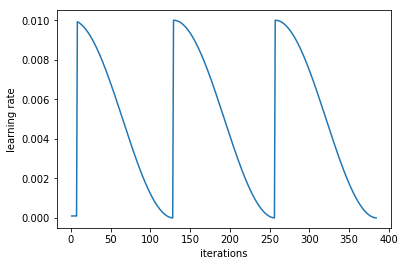

In [7]:
learn.sched.plot_lr()

In [8]:
learn.save("dogbreeds_1")

In [9]:
learn.load("dogbreeds_1")

In [10]:
learn.unfreeze()

As we have unfreezed all the layers, when we train the network, the weights of all the layers are updated. While we'd like to change the weights of later layers by a fair margin, we want to ensure we don't fiddle too much with the weights of the earlier layers. So, we give different learning rates for each layer.

Here, we divide the layers into three logical groups - early conv layers, mid conv layers and end fc layers. We give 3 different lr's to each of these.

In [11]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

 13%|█▎        | 17/128 [00:22<02:27,  1.33s/it, loss=0.855]

# Predict on test set

In [ ]:
preds = np.exp(learn.predict(is_test=True))

In [ ]:
fnames = [x.split("/")[1].split(".")[0] for x in data.test_dl.dataset.fnames]

In [ ]:
final = pd.read_csv(f"{PATH}/sample_submission.csv")
final.loc[:,1:] = preds

In [ ]:
f = "submit1.csv"
final.to_csv(f"{PATH}{f}", compression="gzip", index=False)

from IPython.display import FileLink
FileLink(f"{PATH}{f}")